In [ ]:
from typing import List
from pathlib import Path
import symusic as sm 
import miditoolkit as mtk
import pretty_midi as pm
import partitura as pa
import music21 as m21
import midifile_binding as mf 

import timeit
import os
from time import sleep

ENABLE_TQDM = True

if ENABLE_TQDM:
    from tqdm import tqdm
else:
    def tqdm(iterable, *args, **kwargs):
        return iterable

MIDI_DATASET_NAMES = ('maestro', 'musicnet', 'POP909')
ABC_DATASET_NAMES = ('nottingham',)
DATASET_ROOT = "./symusic_benchmark_datasets"

def is_valid(f: str):
    try:
        sm.Score(f)
        return True
    except:
        return False

print("Scanning datasets to filter out invalid files...")
sleep(0.1)
MIDI_DATASET = {
    name: sorted(list(filter(
        is_valid, 
        tqdm(list(map(str, Path(DATASET_ROOT).joinpath(name).rglob('*.mid*'))), desc=name)
    )))  for name in MIDI_DATASET_NAMES
}

Scanning datasets to filter out invalid files...


POP909: 100%|██████████| 2898/2898 [00:01<00:00, 2446.76it/s]


In [2]:
import os
import random
from typing import List, Dict
from collections import defaultdict

def build_dataset(
    midi_dataset: Dict[str, List[str]], 
    bin_size: int, 
    max_files_per_bin: int, 
    seed: int = 42
) -> List[str]:
    """
    根据文件大小对MIDI文件进行分bin，并返回一个经过筛选的文件路径列表。

    :param midi_dataset: 字典，包含数据集名称和对应的MIDI文件路径列表。
    :param bin_size: 每个bin的大小（单位：KB）。
    :param max_files_per_bin: 每个bin中允许的最大文件数量。
    :param seed: 随机种子，保证复现性。
    :return: 筛选后的MIDI文件路径列表。
    """
    # 设置随机种子，保证选择的可复现性
    random.seed(seed)

    # 创建一个字典来存储每个bin中的文件路径
    bins = defaultdict(list)
    
    # 遍历所有MIDI文件并根据文件大小分bin
    for files in midi_dataset.values():
        # 对文件路径进行排序，保证每次的顺序一致
        sorted_files = sorted(files)
        for file_path in sorted_files:
            file_size = os.path.getsize(file_path) / 1024  # 文件大小，单位为KB
            bin_index = int(file_size // bin_size)
            bins[bin_index].append(file_path)
    
    # 根据每个bin的上限进行筛选
    selected_files = []
    for bin_files in bins.values():
        # 如果某个bin中的文件数量大于上限，则随机选择其中的文件
        if len(bin_files) > max_files_per_bin:
            selected_files.extend(random.sample(bin_files, max_files_per_bin))
        else:
            selected_files.extend(bin_files)
    
    return selected_files

# 合并所有数据集中的文件路径
all_midi_files = build_dataset(MIDI_DATASET, bin_size=50, max_files_per_bin=4, seed=42)
print(f"Number of MIDI files: {len(all_midi_files)} / {sum(len(files) for files in MIDI_DATASET.values())}")

Number of MIDI files: 32 / 4497


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import timeit
import os
from tqdm import tqdm
import pandas as pd
import multiprocessing

# 测试读取和写入时间的函数，使用传入的读取和写入函数以及重复次数
def benchmark_read_write(library_funcs, file_paths, repeat=1, use_multiprocessing=False):
    read_times = []
    write_times = []
    sizes = []
    read_func = library_funcs['read']
    write_func = library_funcs['write']

    if use_multiprocessing:
        cpu_count = multiprocessing.cpu_count() // 2
        with multiprocessing.Pool(cpu_count) as pool:
            results = list(tqdm(pool.imap(measure_read_write_wrapper, [(path, read_func, write_func, repeat) for path in file_paths]), desc="Read and Write Benchmark", total=len(file_paths)))
        
        for size, read_time, write_time in results:
            sizes.append(size)
            read_times.append(read_time)
            write_times.append(write_time)
    else:
        for idx, path in enumerate(tqdm(file_paths, desc="Read and Write Benchmark")):
            size, avg_read_time, avg_write_time = measure_read_write(path, read_func, write_func, repeat)
            sizes.append(size)
            read_times.append(avg_read_time)
            write_times.append(avg_write_time)

    return sizes, read_times, write_times

# 测量单个文件的读取和写入时间
def measure_read_write_wrapper(args):
    return measure_read_write(*args)

def measure_read_write(path, read_func, write_func, repeat):
    size = os.path.getsize(path) / 1024  # 文件大小，单位为KB
    
    # 测试读取时间
    start_time = timeit.default_timer()
    midi_object = None
    for _ in range(repeat):
        midi_object = read_func(path)
    read_total_time = timeit.default_timer() - start_time
    avg_read_time = read_total_time / repeat
    
    # 测试写入时间
    start_time = timeit.default_timer()
    for i in range(repeat):
        temp_path = f"temp_{os.path.basename(path)}_{i}.mid"
        write_func(midi_object, temp_path)  # 写入操作
    write_total_time = timeit.default_timer() - start_time
    avg_write_time = write_total_time / repeat

    # 删除临时文件
    for i in range(repeat):
        temp_path = f"temp_{os.path.basename(path)}_{i}.mid"
        if os.path.exists(temp_path):
            os.remove(temp_path)
    
    return size, avg_read_time, avg_write_time

def music21_read(path):
    return m21.converter.parse(path)

def music21_write(midi_obj, path):
    midi_obj.write('midi', path)

def mtk_write(midi_obj, path):
    midi_obj.dump(path)

def pm_write(midi_obj, path):
    midi_obj.write(path)

def mf_write(midi_obj, path):
    midi_obj.dump_midi(path)

# 定义不同库的读取和写入操作
LIBRARIES = {
    'miditoolkit': {
        'read': mtk.MidiFile,
        'write': mtk_write,
        'repeat': 1,
        'color': 'blue',
        'line_color': 'darkblue',
        'mp': False
    },
    'symusic': {
        'read': lambda path: sm.Score(path),
        'write': lambda midi_obj, path: midi_obj.dump_midi(path),
        'repeat': 32,
        'color': 'green',
        'line_color': 'darkgreen',
        'mp': False
    },
    'pretty_midi': {
        'read': pm.PrettyMIDI,
        'write': pm_write,
        'repeat': 1,
        'color': 'orange',
        'line_color': 'darkorange',
        'mp': False
    },
    'music21': {
        'read': music21_read,
        'write': music21_write,
        'repeat': 1,
        'color': 'purple',
        'line_color': 'darkviolet',
        'mp': False
    },
    'partitura': {
        'read': pa.load_performance_midi,
        'write': pa.save_performance_midi,
        'repeat': 1,
        'color': 'red',
        'line_color': 'darkred',
        'mp': False
    },
    'midifile_cpp': {
        'read': mf.load,
        'write': mf_write,
        'repeat': 8,
        'color': 'black',
        'line_color': 'black',
        'mp': False
    }
}

# 要测试的库列表
# LIBRARY_LIST = ['symusic', 'music21']
LIBRARY_LIST = ['symusic', 'miditoolkit', 'pretty_midi', 'partitura']
# LIBRARY_LIST = ['music21']

# 存储benchmark结果的字典
benchmark_results = {
    'read': {},
    'write': {}
}

# 执行benchmark
for lib in LIBRARY_LIST:
    print(f"Benchmarking {lib} READ and WRITE ...")
    sizes, read_times, write_times = benchmark_read_write(LIBRARIES[lib], all_midi_files, repeat=LIBRARIES[lib]['repeat'], use_multiprocessing=LIBRARIES[lib]['mp'])
    
    benchmark_results['read'][lib] = (sizes, read_times)
    benchmark_results['write'][lib] = (sizes, write_times)
    benchmark_results['write'][lib] = (sizes, write_times)

# 创建结果文件夹
os.makedirs('results', exist_ok=True)

# 保存结果为 CSV 文件（每个库保存两个文件：读和写）
for lib in LIBRARY_LIST:
    sizes, read_times = benchmark_results['read'][lib]
    read_df = pd.DataFrame({'File Size (KB)': sizes, 'Read Time (s)': read_times})
    read_df.to_csv(f'results/{lib}_read.csv', index=False)
    
    sizes, write_times = benchmark_results['write'][lib]
    write_df = pd.DataFrame({'File Size (KB)': sizes, 'Write Time (s)': write_times})
    write_df.to_csv(f'results/{lib}_write.csv', index=False)

Benchmarking symusic READ and WRITE ...


Read and Write Benchmark: 100%|██████████| 32/32 [00:04<00:00,  6.51it/s]


Benchmarking miditoolkit READ and WRITE ...


Read and Write Benchmark: 100%|██████████| 32/32 [00:42<00:00,  1.32s/it]


Benchmarking pretty_midi READ and WRITE ...


Read and Write Benchmark: 100%|██████████| 32/32 [00:59<00:00,  1.86s/it]


Benchmarking partitura READ and WRITE ...


Read and Write Benchmark:   0%|          | 0/32 [00:00<?, ?it/s]c:\Users\lyk-b\miniforge3\Lib\site-packages\partitura\io\importmidi.py:245: UserWarning: ignoring MIDI message note_off channel=0 note=74 velocity=64 time=11
  warnings.warn(f"ignoring MIDI message {msg}")
c:\Users\lyk-b\miniforge3\Lib\site-packages\partitura\io\importmidi.py:245: UserWarning: ignoring MIDI message note_off channel=0 note=74 velocity=64 time=62
  warnings.warn(f"ignoring MIDI message {msg}")
c:\Users\lyk-b\miniforge3\Lib\site-packages\partitura\io\importmidi.py:245: UserWarning: ignoring MIDI message note_off channel=0 note=74 velocity=64 time=24
  warnings.warn(f"ignoring MIDI message {msg}")
c:\Users\lyk-b\miniforge3\Lib\site-packages\partitura\io\importmidi.py:245: UserWarning: ignoring MIDI message note_off channel=2 note=58 velocity=64 time=54
  warnings.warn(f"ignoring MIDI message {msg}")
Read and Write Benchmark:   9%|▉         | 3/32 [00:01<00:13,  2.14it/s]c:\Users\lyk-b\miniforge3\Lib\site-packa

In [4]:
# 解析benchmark结果的函数
def load_benchmark_results(results_path):
    benchmark_results = {
        'read': {},
        'write': {}
    }
    
    for lib in LIBRARY_LIST:
        print(lib)
        read_df = pd.read_csv(os.path.join(results_path, f'{lib}_read.csv'))
        write_df = pd.read_csv(os.path.join(results_path, f'{lib}_write.csv'))
        
        benchmark_results['read'][lib] = (read_df['File Size (KB)'].tolist(), read_df['Read Time (s)'].tolist())
        benchmark_results['write'][lib] = (write_df['File Size (KB)'].tolist(), write_df['Write Time (s)'].tolist())
    
    return benchmark_results

# LIBRARY_LIST = ['miditoolkit', 'symusic', 'pretty_midi', 'music21']
benchmark_results = load_benchmark_results('results')

symusic
miditoolkit
pretty_midi
partitura


{'read': <function <lambda> at 0x000001299AC09D00>, 'write': <function <lambda> at 0x000001299AC09C60>, 'repeat': 32, 'color': 'green', 'line_color': 'darkgreen', 'mp': False}
{'read': <class 'miditoolkit.midi.parser.MidiFile'>, 'write': <function mtk_write at 0x000001299AC09B20>, 'repeat': 1, 'color': 'blue', 'line_color': 'darkblue', 'mp': False}
{'read': <class 'pretty_midi.pretty_midi.PrettyMIDI'>, 'write': <function pm_write at 0x000001299AC09BC0>, 'repeat': 1, 'color': 'orange', 'line_color': 'darkorange', 'mp': False}
{'read': <function load_performance_midi at 0x0000012996108C20>, 'write': <function save_performance_midi at 0x0000012999EBE7A0>, 'repeat': 1, 'color': 'red', 'line_color': 'darkred', 'mp': False}


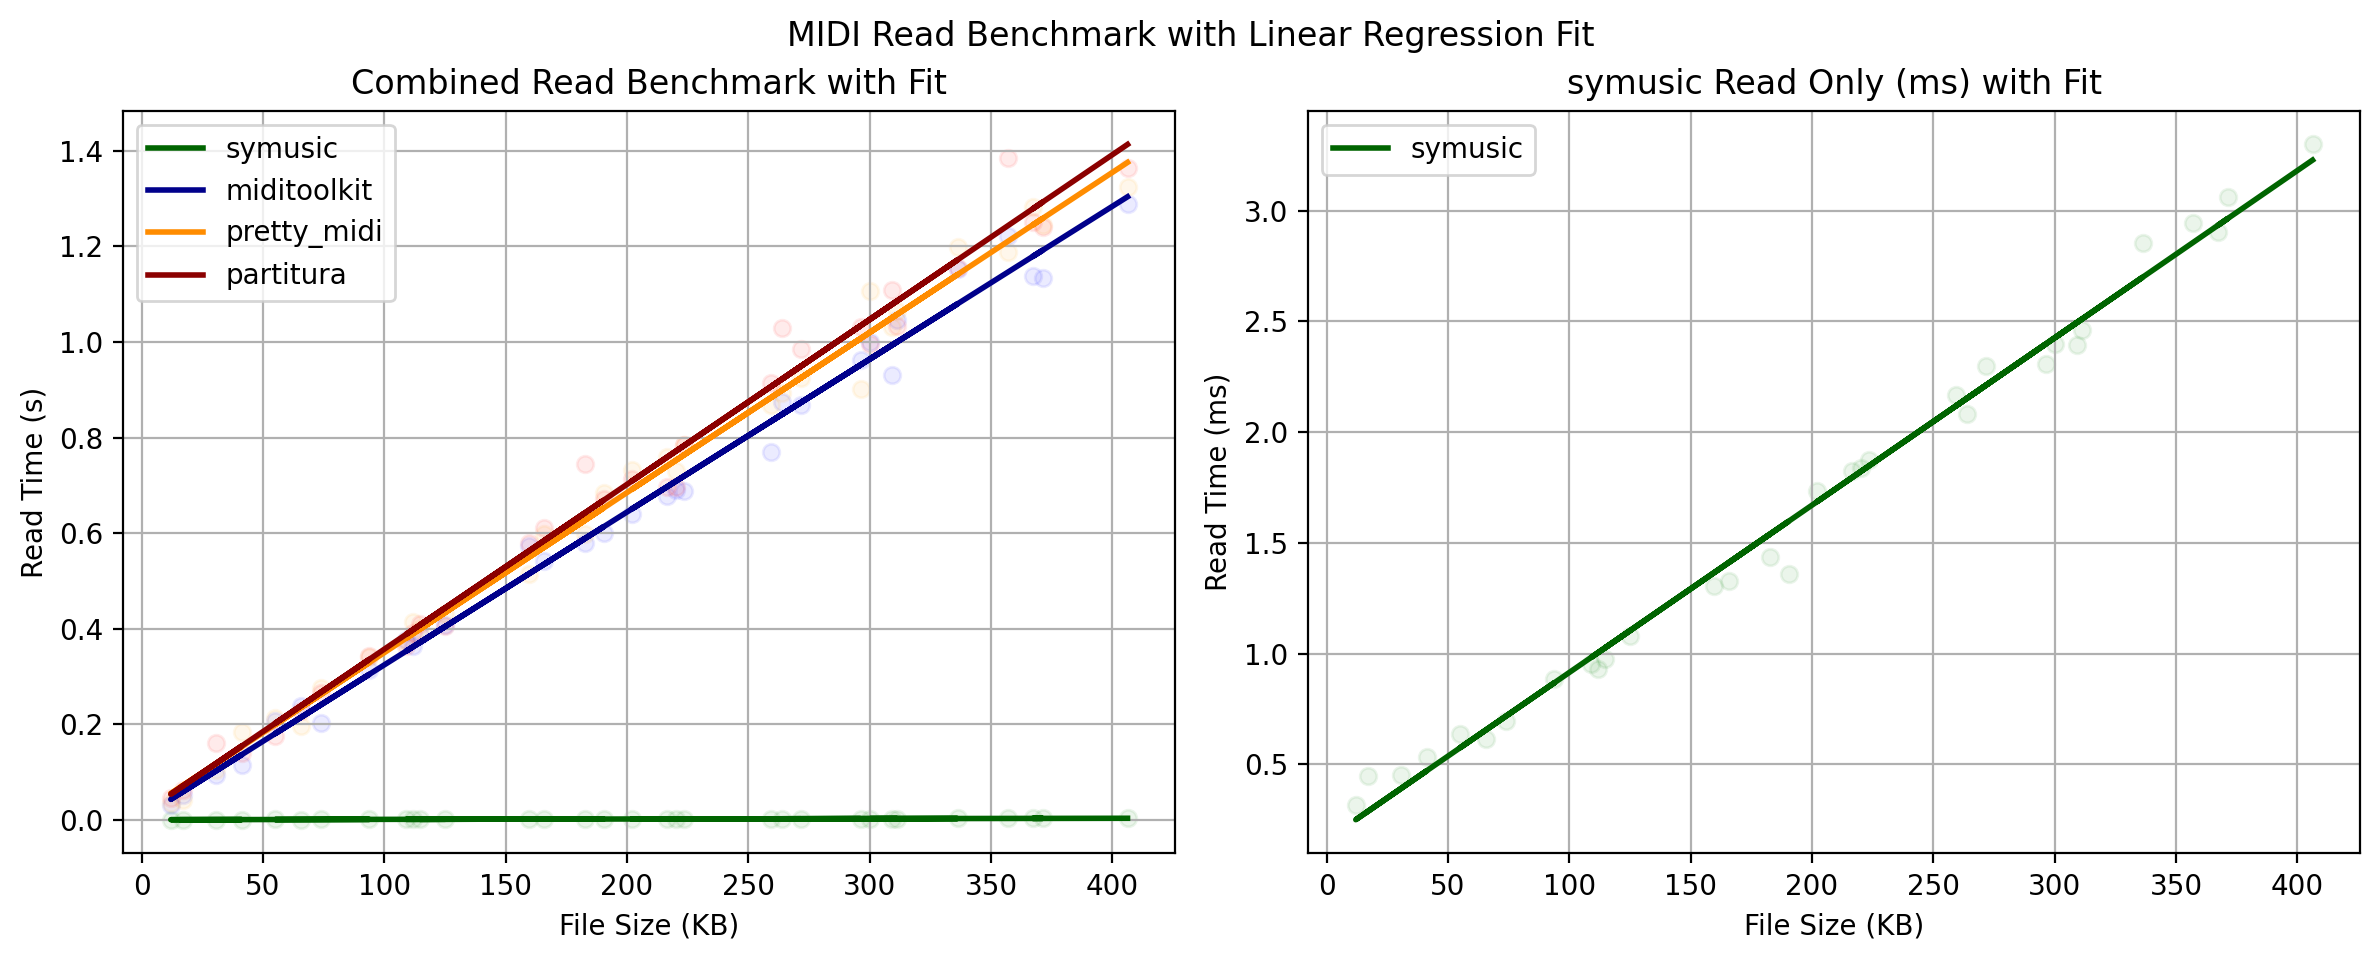

In [6]:
# 绘图部分
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# 定义透明度变量
ALPHA = 0.08
# remove music21 from the list
# if 'music21' in LIBRARY_LIST:
    # LIBRARY_LIST.remove('music21')

# 绘制读速图
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# 所有库的读速图
for lib in LIBRARY_LIST:
    sizes, times = benchmark_results['read'][lib]
    X = np.array(sizes).reshape(-1, 1)
    y = np.array(times)
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    print(LIBRARIES[lib])
    color = LIBRARIES[lib]['color']

    line_color = LIBRARIES[lib]['line_color']
    ax1.scatter(sizes, times, color=color, label='_nolegend_', alpha=ALPHA)
    ax1.plot(sizes, y_pred, color=line_color, linestyle='-', linewidth=2, label=lib)

ax1.set_xlabel('File Size (KB)')
ax1.set_ylabel('Read Time (s)')
ax1.set_title('Combined Read Benchmark with Fit')
ax1.legend()
ax1.grid(True)

# 单独绘制 symusic 的读速图，时间单位为毫秒(ms)
symusic_sizes, symusic_read_times = benchmark_results['read']['symusic']
symusic_X = np.array(symusic_sizes).reshape(-1, 1)
symusic_y = np.array(symusic_read_times)
symusic_model = LinearRegression()
symusic_model.fit(symusic_X, symusic_y)
symusic_y_pred = symusic_model.predict(symusic_X)

ax2.scatter(symusic_sizes, [time * 1000 for time in symusic_read_times], color=LIBRARIES['symusic']['color'], label='_nolegend_', alpha=ALPHA)
ax2.plot(symusic_sizes, symusic_y_pred * 1000, color=LIBRARIES['symusic']['line_color'], linestyle='-', linewidth=2, label='symusic')
ax2.set_xlabel('File Size (KB)')
ax2.set_ylabel('Read Time (ms)')
ax2.set_title('symusic Read Only (ms) with Fit')
ax2.grid(True)
ax2.legend()

plt.suptitle('MIDI Read Benchmark with Linear Regression Fit', y=0.95)
plt.tight_layout()
plt.show()

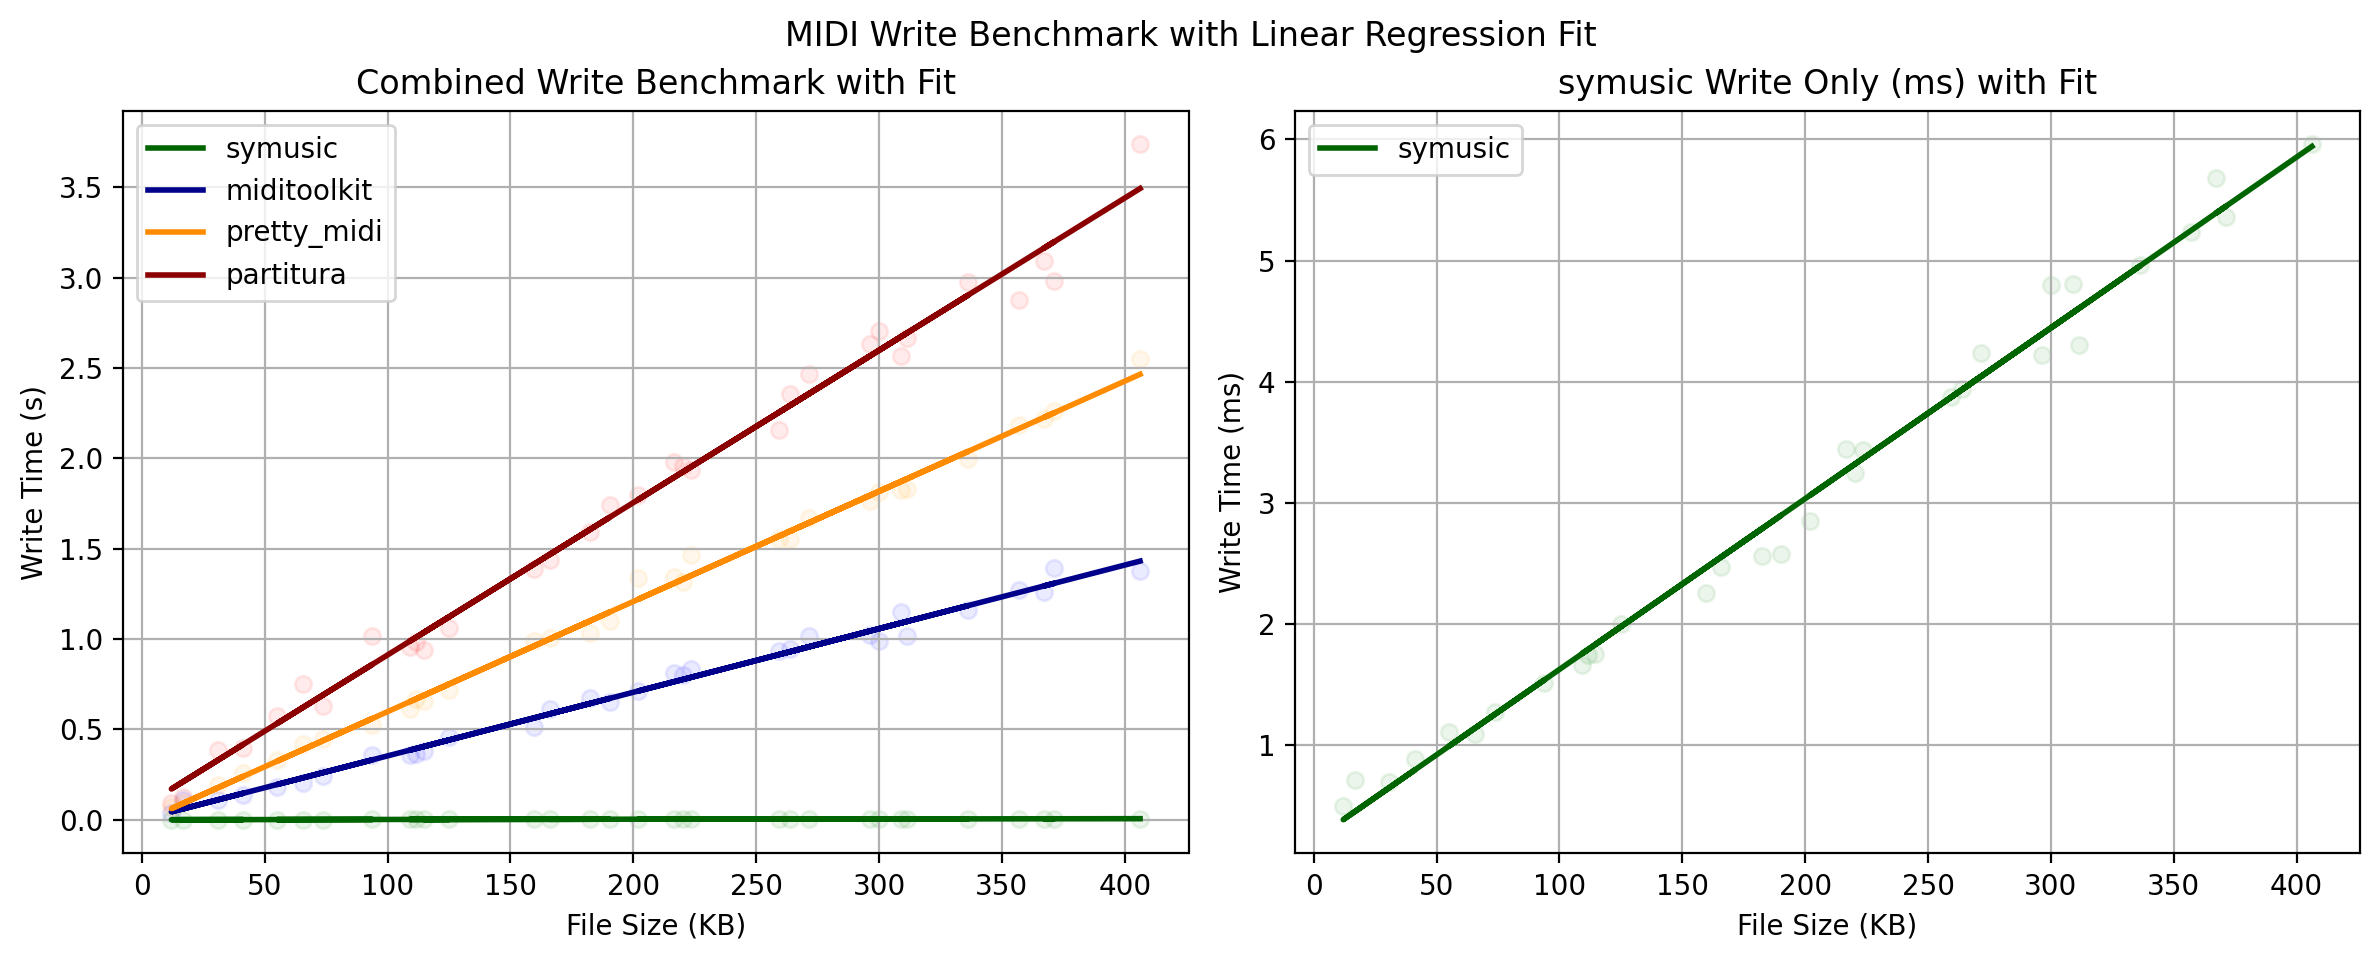

In [7]:
# 绘制写速图
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# 所有库的写速图
for lib in LIBRARY_LIST:
    sizes, times = benchmark_results['write'][lib]
    X = np.array(sizes).reshape(-1, 1)
    y = np.array(times)
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    
    color = LIBRARIES[lib]['color']
    line_color = LIBRARIES[lib]['line_color']
    ax1.scatter(sizes, times, color=color, label='_nolegend_', alpha=ALPHA)
    ax1.plot(sizes, y_pred, color=line_color, linestyle='-', linewidth=2, label=lib)

ax1.set_xlabel('File Size (KB)')
ax1.set_ylabel('Write Time (s)')
ax1.set_title('Combined Write Benchmark with Fit')
ax1.legend()
ax1.grid(True)

# 单独绘制 symusic 的写速图，时间单位为毫秒(ms)
symusic_sizes, symusic_write_times = benchmark_results['write']['symusic']
symusic_X = np.array(symusic_sizes).reshape(-1, 1)
symusic_y = np.array(symusic_write_times)
symusic_model = LinearRegression()
symusic_model.fit(symusic_X, symusic_y)
symusic_y_pred = symusic_model.predict(symusic_X)

ax2.scatter(symusic_sizes, [time * 1000 for time in symusic_write_times], color=LIBRARIES['symusic']['color'], label='_nolegend_', alpha=ALPHA)
ax2.plot(symusic_sizes, symusic_y_pred * 1000, color=LIBRARIES['symusic']['line_color'], linestyle='-', linewidth=2, label='symusic')
ax2.set_xlabel('File Size (KB)')
ax2.set_ylabel('Write Time (ms)')
ax2.set_title('symusic Write Only (ms) with Fit')
ax2.grid(True)
ax2.legend()

plt.suptitle('MIDI Write Benchmark with Linear Regression Fit', y=0.95)
plt.tight_layout()
plt.show()


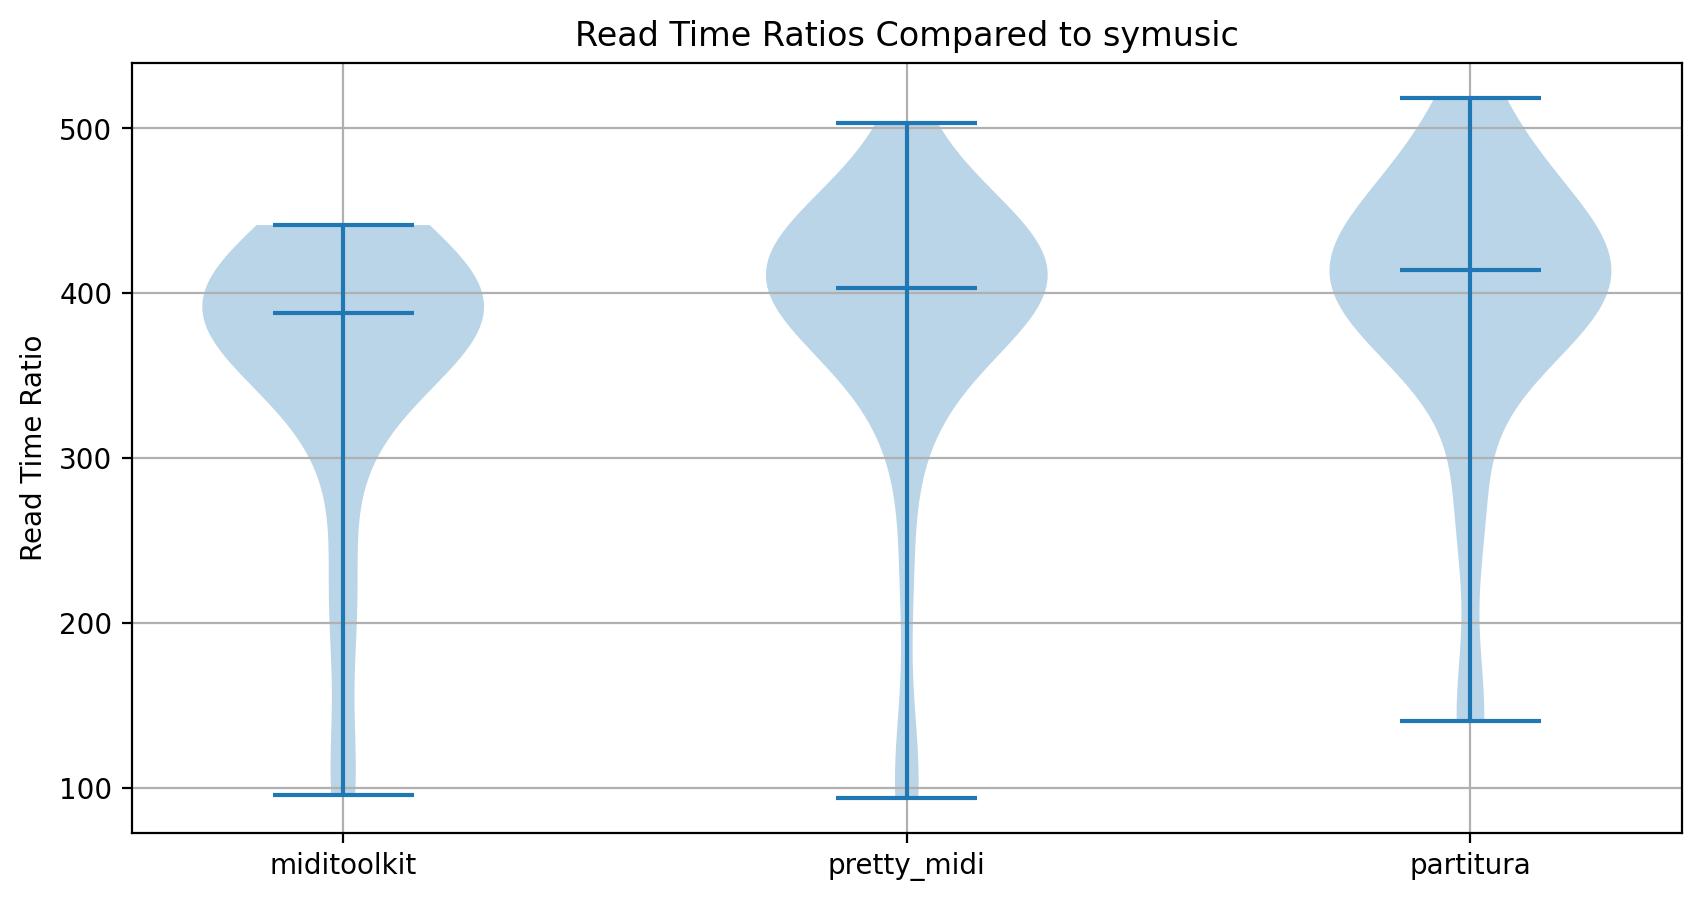

In [8]:
# 以 symusic 为基准，计算其他库的读写速度比，例如 time_mt / time_sm，然后绘制小提琴图
# 读速度比
read_ratios = {}
write_ratios = {}

for lib in LIBRARY_LIST:
    if lib == 'symusic':
        continue
    read_ratios[lib] = np.array(benchmark_results['read'][lib][1]) / np.array(benchmark_results['read']['symusic'][1])
    write_ratios[lib] = np.array(benchmark_results['write'][lib][1]) / np.array(benchmark_results['write']['symusic'][1])

# 读速度比的小提琴图
plt.figure(figsize=(10, 5))
plt.violinplot(read_ratios.values(), showmedians=True)
plt.xticks(ticks=np.arange(1, len(read_ratios) + 1), labels=read_ratios.keys())
plt.title('Read Time Ratios Compared to symusic')
plt.ylabel('Read Time Ratio')
plt.grid(True)
plt.show()


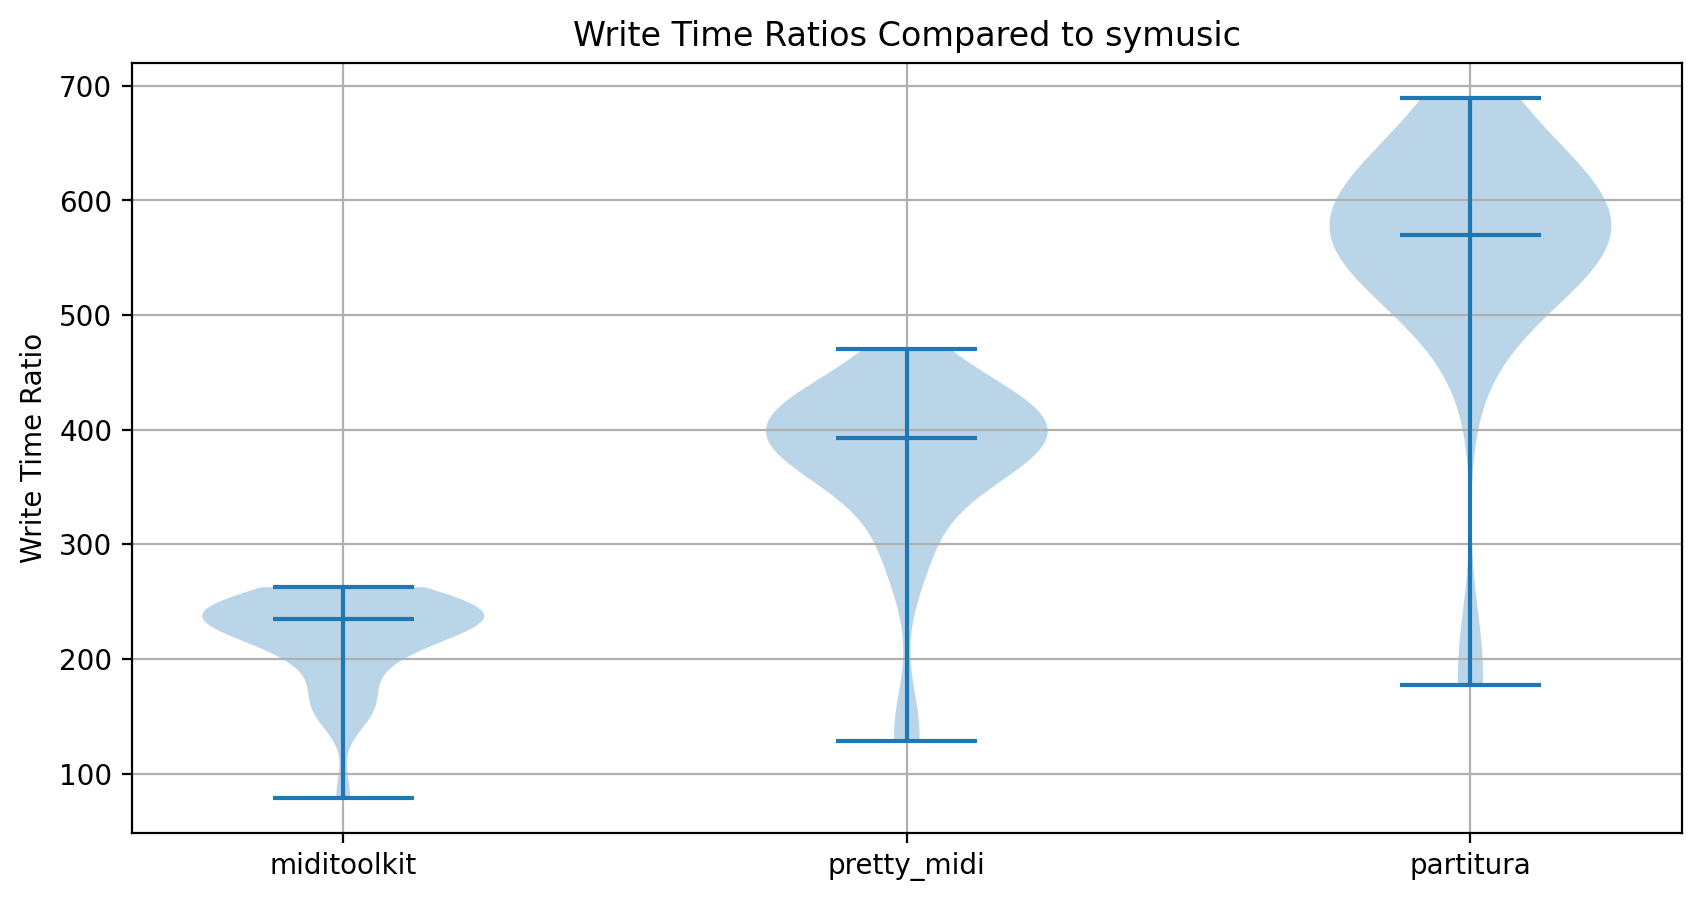

In [9]:
# 写速度比的小提琴图
plt.figure(figsize=(10, 5))
plt.violinplot(write_ratios.values(), showmedians=True)
plt.xticks(ticks=np.arange(1, len(write_ratios) + 1), labels=write_ratios.keys())
plt.title('Write Time Ratios Compared to symusic')
plt.ylabel('Write Time Ratio')
plt.grid(True)
plt.show()